<a href="https://colab.research.google.com/github/FajarWahyuSuryaputra/Pembelajaran_Mesin/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install tensorflow

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [104]:
data = pd.read_excel('AirQualityUCI.xlsx')

print(f'jumlah column dan entries: {data.shape}')
data.info()
data.describe()

jumlah column dan entries: (9357, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   flo

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2004-09-21 04:30:05.193972480,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
min,2004-03-10 00:00:00,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,2004-06-16 00:00:00,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,2004-09-21 00:00:00,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2004-12-28 00:00:00,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,2005-04-04 00:00:00,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036
std,NaN,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670


In [105]:
print(data.isnull().sum())

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


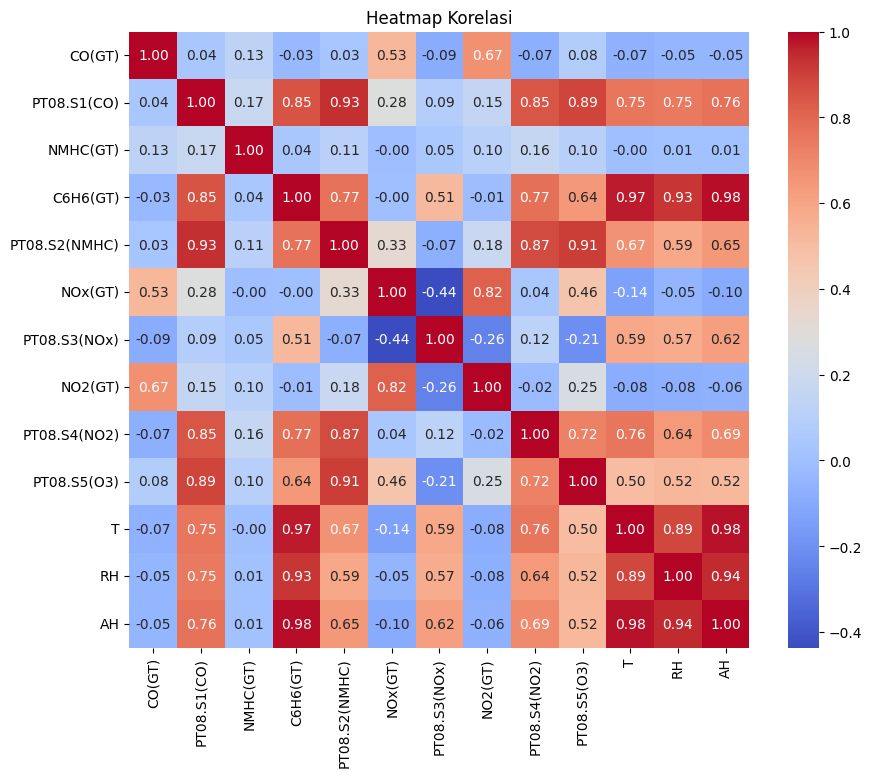

In [106]:
# Heatmap Korelasi
plt.figure(figsize=(10, 8))
# Pilih hanya kolom numerik
numeric_data = data.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()

In [107]:
# Seleksi Fitur
X = data[
    ['PT08.S1(CO)',
    'C6H6(GT)',
    'T',
    'RH',]
]
y = data['AH']

# Seleksi fitur menggunakan SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')
X_new = selector.fit_transform(X, y)

# Menampilkan skor fitur
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
print("\nSkor Fitur:")
print(feature_scores)


Skor Fitur:
       Feature          Score
0  PT08.S1(CO)   13188.227653
1     C6H6(GT)  295863.969244
2            T  239161.027134
3           RH   76573.682983


In [108]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(X_new)

In [109]:
def sequence(data, timesteps=10):
  X_seq, y_seq = [], []
  for i in range(len(data) - timesteps):
    X_seq.append(data[i:i+timesteps])
    y_seq.append(data[i+timesteps -1][0])
  return np.array(X_seq), np.array(y_seq)

timesteps = 10
X_sequence, y_sequence = sequence(data_scaled, timesteps)
print(X_sequence.shape)
print(y_sequence.shape)

(9347, 10, 4)
(9347,)


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y_sequence, test_size=0.2, random_state=42)

print('Data training:', X_train.shape, y_train.shape)
print('Data testing:', X_test.shape, y_test.shape)

Data training: (7477, 10, 4) (7477,)
Data testing: (1870, 10, 4) (1870,)


In [116]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0482 - val_loss: 0.0059
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 7.3469e-04
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2830e-04 - val_loss: 3.9518e-04
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1234e-04 - val_loss: 2.8176e-04
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1947e-04 - val_loss: 2.3176e-04
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3261e-04 - val_loss: 2.0364e-04
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0744e-04 - val_loss: 1.0303e-04
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9508e-05 - val_loss: 5.9823e-05
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7044e-05 - val_loss: 7.7

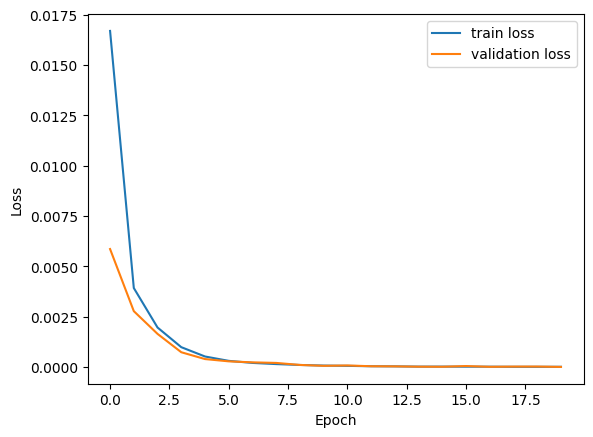

In [118]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [119]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

predictions = model.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1995e-06
Test Loss: 3.994441613031086e-06
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [120]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 3.994443526524566e-06
RMSE: 0.0019986103988833257
